In [24]:
# !pip install ultralyticsplus 

In [1]:
# !pip install PyQt5

### Imports

In [2]:
# !pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
import pickle
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import torch
# import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont

from PIL import Image, ImageDraw
# from ultralytics import YOLO
# from ultralyticsplus import render_result

import cv2
import cv2 as cv
import numpy as np

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)

In [6]:
from object_detection_utils import (
    COLORS,
    preprocess, 
    box_cxcywh_to_xyxy, 
    rescale_bboxes,
    batch_detect,
    detect, 
    plot_results,
    plot_batch_detections,
    plot_batch_detections,
    plot_results_avenue,
    load_images_from_folder,
    list_image_files,
    save_cropped_images,
)

In [7]:
def plot_results_avenue(pil_img, prob, boxes, im_size=(640, 360), display_img=True, save_path=None, crop_objects=False):
    orig_width, orig_height = pil_img.size
    scale_x = orig_width / im_size[0]
    scale_y = orig_height / im_size[1]

    # Create a copy of the image for cropping
    pil_img_copy = pil_img.copy()

    draw = ImageDraw.Draw(pil_img)
    font = ImageFont.load_default()  # Can be changed to another font

    cropped_images = []  # List to hold cropped objects

    for (xmin, ymin, xmax, ymax), c in zip(boxes, COLORS * 100):
        xmin, xmax = xmin * scale_x, xmax * scale_x
        ymin, ymax = ymin * scale_y, ymax * scale_y

        color = tuple(int(255 * x) for x in c)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)

        if crop_objects:
            # Cropping from the unaltered image copy
            cropped_obj = pil_img_copy.crop((xmin, ymin, xmax, ymax))
            cropped_images.append(cropped_obj)

        # Optionally add class text
        # cl = p.argmax()
        # text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        # draw.text((xmin, ymin), text, fill=color, font=font)

    if display_img:
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        plt.axis('off')
        plt.show()

    if save_path:
        pil_img.save(save_path)

    return pil_img, cropped_images

In [8]:
def show_image(input_image, window_name='image', timeout=0):
    """
    Display an image in a window, resized to 40% of its original dimensions.

    Args:
        input_image (numpy array): The input image to display.
        window_name (str, optional): The name of the window displaying the image. Defaults to 'image'.
        timeout (int, optional): The number of milliseconds to wait before closing the window. Defaults to 0.

    Note:
        If the timeout is set to 0, the window will not close automatically.
    """
    resized_image = cv.resize(
        input_image,
        (int(input_image.shape[1] * 0.4), int(input_image.shape[0] * 0.4))
    )

    cv.imshow(window_name, resized_image)
    cv.waitKey(timeout)
    cv.destroyAllWindows()

### Load Model

In [9]:
modelConfiguration = './pretrained/yolov3-spp.cfg'
modelWeights = './pretrained/yolov3-spp.weights'

# modelConfiguration = './' -> video 6 task 3 greseste 1, cam 12 min
# modelWeights = './'
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Load names of classes from coco
classes = None
with open('./pretrained/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Get the output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

### Test on 1 Img

In [10]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
nmsThreshold = 0.4   # Non-maximum suppression threshold

[ WARN:0@4.236] global net_impl.cpp:178 setUpNet DNN module was not built with CUDA backend; switching to CPU


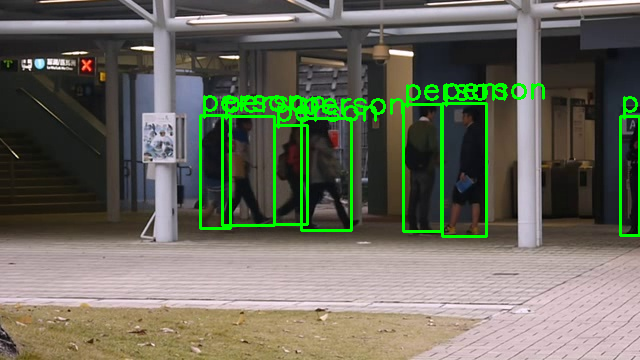

In [11]:
# Load image with PIL
input_image_path = './datasets/Avenue Dataset/train__/01/0017.jpg'
input_image = Image.open(input_image_path)

# Convert the PIL image to a numpy array and then to the color scheme expected by OpenCV (BGR)
input_image_np = np.array(input_image)[:, :, ::-1].copy()  # Convert RGB to BGR

# Get image dimensions
image_height, image_width, image_channels = input_image_np.shape

# Create a 4D blob from image, with given parameters
blob = cv2.dnn.blobFromImage(input_image_np, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)

# Execute a forward pass through the network to get output from the output layers
output_layers_data = net.forward(output_layers)

detected_classes = []
detection_confidences = []
bounding_boxes = []

for output_layer in output_layers_data:
    for detected_object in output_layer:
        scores = detected_object[5:]
        class_index = np.argmax(scores)
        object_confidence = scores[class_index]

        # Filter for classes of interest
        if object_confidence > 0.5:
            # Object has been detected
            center_x = int(detected_object[0] * image_width)
            center_y = int(detected_object[1] * image_height)
            box_width = int(detected_object[2] * image_width)
            box_height = int(detected_object[3] * image_height)

            # Rectangle coordinates
            x_coord = int(center_x - box_width / 2)
            y_coord = int(center_y - box_height / 2)

            bounding_boxes.append([x_coord, y_coord, box_width, box_height])
            detection_confidences.append(float(object_confidence))
            detected_classes.append(class_index)

valid_indexes = cv2.dnn.NMSBoxes(bounding_boxes, detection_confidences, 0.5, 0.3)
final_rectangles = []

for i in range(len(bounding_boxes)):
    if i in valid_indexes:
        x, y, box_width, box_height = bounding_boxes[i]
        object_label = str(classes[detected_classes[i]])
        cv2.rectangle(input_image_np, (x, y), (x + box_width, y + box_height), (0,255,0), 2)
        cv2.putText(input_image_np, object_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        # x_min, y_min, x_max, y_max
        final_rectangles.append([x, y, x+box_width,y+ box_height])

# Convert the image back to RGB and then to a PIL image for display
input_image_pil = Image.fromarray(input_image_np[:, :, ::-1])  # Convert BGR to RGB
input_image_pil.show()

In [12]:
import os

# Directory where the cropped images will be saved
output_dir = './cropped_objects'
os.makedirs(output_dir, exist_ok=True)

for i, (x_min, y_min, x_max, y_max) in enumerate(final_rectangles):
    # Crop the detected object out of the original image
    cropped_img = input_image.crop((x_min, y_min, x_max, y_max))

    # Construct the file name and save the cropped image
    output_image_path = os.path.join(output_dir, f'object_{i}_{detected_classes[i]}.jpg')
    cropped_img.save(output_image_path)

print(f"Cropped objects have been saved in {output_dir}")


Cropped objects have been saved in ./cropped_objects


In [13]:
# # Copy the image to prevent in-place modifications

# from PIL import Image 

# # input_image = Image.open('./datasets/Avenue Dataset/train__/01/0017.jpg')  

# # Load image
# # image_tensor, image = preprocess('./datasets/Avenue Dataset/train__/01/0017.jpg')
# input_image = cv2.imread('./datasets/Avenue Dataset/train__/01/0017.jpg')

# image_copy = input_image.copy()
# image_height, image_width, image_channels = image_copy.size

# # Create a 4D blob from image, with given parameters
# blob = cv2.dnn.blobFromImage(image_copy, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

# net.setInput(blob)

# # Execute a forward pass through the network to get output from the output layers
# output_layers_data = net.forward(output_layers)

# detected_classes = []
# detection_confidences = []
# bounding_boxes = []

# for output_layer in output_layers_data:
#     for detected_object in output_layer:
#         scores = detected_object[5:]
#         class_index = np.argmax(scores)
#         object_confidence = scores[class_index]

#         # Filter for classes of interest
#         if object_confidence > 0.5:
#             # Object has been detected
#             center_x = int(detected_object[0] * image_width)
#             center_y = int(detected_object[1] * image_height)
#             box_width = int(detected_object[2] * image_width)
#             box_height = int(detected_object[3] * image_height)

#             # Rectangle coordinates
#             x_coord = int(center_x - box_width / 2)
#             y_coord = int(center_y - box_height / 2)

#             bounding_boxes.append([x_coord, y_coord, box_width, box_height])
#             detection_confidences.append(float(object_confidence))
#             detected_classes.append(class_index)

# valid_indexes = cv2.dnn.NMSBoxes(bounding_boxes, detection_confidences, 0.5, 0.3)
# final_rectangles = []

# for i in range(len(bounding_boxes)):
#     if i in valid_indexes:
#         x, y, box_width, box_height = bounding_boxes[i]
#         object_label = str(classes[detected_classes[i]])
#         cv2.rectangle(image_copy, (x, y), (x + box_width, y + box_height), (0,255,0), 2)
#         cv2.putText(image_copy, object_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
#         # x_min, y_min, x_max, y_max
#         final_rectangles.append([x, y, x+box_width,y+ box_height])

# # show_image(image_copy)

### Benchmark

In [38]:
# %%timeit -n 100
# # benchmark
# with torch.no_grad():
#     # Run the model on the batch
#     outputs = model(pixel_values=batch_images)

### Avenue Prediction using YOLOv3

In [14]:
train_dir = "./datasets/Avenue Dataset/train__/"
train_video_dirs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir, dir)
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/train__/01 1364
./datasets/Avenue Dataset/train__/02 1511
./datasets/Avenue Dataset/train__/03 1487
./datasets/Avenue Dataset/train__/04 1511
./datasets/Avenue Dataset/train__/05 815
./datasets/Avenue Dataset/train__/06 1511
./datasets/Avenue Dataset/train__/07 1099
./datasets/Avenue Dataset/train__/08 1017
./datasets/Avenue Dataset/train__/09 1391
./datasets/Avenue Dataset/train__/10 1223
./datasets/Avenue Dataset/train__/11 781
./datasets/Avenue Dataset/train__/12 145
./datasets/Avenue Dataset/train__/13 366
./datasets/Avenue Dataset/train__/14 510
./datasets/Avenue Dataset/train__/15 353
./datasets/Avenue Dataset/train__/16 244
Total Frames: 15328


In [15]:
test_dir = "./datasets/Avenue Dataset/test__/"
test_video_dirs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/test__/01 1439
./datasets/Avenue Dataset/test__/02 1211
./datasets/Avenue Dataset/test__/03 923
./datasets/Avenue Dataset/test__/04 947
./datasets/Avenue Dataset/test__/05 1007
./datasets/Avenue Dataset/test__/06 1283
./datasets/Avenue Dataset/test__/07 605
./datasets/Avenue Dataset/test__/08 36
./datasets/Avenue Dataset/test__/09 1175
./datasets/Avenue Dataset/test__/10 841
./datasets/Avenue Dataset/test__/11 472
./datasets/Avenue Dataset/test__/12 1271
./datasets/Avenue Dataset/test__/13 549
./datasets/Avenue Dataset/test__/14 507
./datasets/Avenue Dataset/test__/15 1001
./datasets/Avenue Dataset/test__/16 740
./datasets/Avenue Dataset/test__/17 426
./datasets/Avenue Dataset/test__/18 294
./datasets/Avenue Dataset/test__/19 248
./datasets/Avenue Dataset/test__/20 273
./datasets/Avenue Dataset/test__/21 76
Total Frames: 15324


In [16]:
preds_path = "./datasets/Avenue Dataset/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
print(train_preds_path, test_preds_path)

./datasets/Avenue Dataset/predictions/train/ ./datasets/Avenue Dataset/predictions/test/


In [17]:
objects_path = "./datasets/Avenue Dataset/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
print(train_objects_path, test_objects_path)

./datasets/Avenue Dataset/objects/train/ ./datasets/Avenue Dataset/objects/test/


In [18]:
image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names)

['00.jpg', '01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg']


### Generate Train Objects and predictions

In [46]:
bbox_temp = {}
video_names = [video.split('/')[-1] for video in train_video_paths]
print(video_names)
# obj_det_dict = {}

for i, video_path in enumerate(train_video_paths):
    print(video_path)
    image_names = [img.split('/')[-1] for img in list_image_files(train_video_paths[i])]

    frame_idx = 0
    for image_name in image_names:
        full_image_path = os.path.join(train_video_paths[i], image_name)

        # Load image
#         input_image = cv2.imread(full_image_path)
        input_image = Image.open(full_image_path)
    
        # Convert the PIL image to a numpy array and then to the color scheme expected by OpenCV (BGR)
        input_image_np = np.array(input_image)[:, :, ::-1].copy()  # Convert RGB to BGR

        # Create a 4D blob from image, with given parameters
        blob = cv2.dnn.blobFromImage(input_image_np, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)

        # Execute a forward pass through the network to get output from the output layers
        output_layers_data = net.forward(output_layers)

        detected_classes = []
        detection_confidences = []
        bounding_boxes = []

        for output_layer in output_layers_data:
            for detected_object in output_layer:
                scores = detected_object[5:]
                class_index = np.argmax(scores)
                object_confidence = scores[class_index]

                # Filter for classes of interest
                if object_confidence > 0.5:
                    # Object has been detected
                    center_x = int(detected_object[0] * image_width)
                    center_y = int(detected_object[1] * image_height)
                    box_width = int(detected_object[2] * image_width)
                    box_height = int(detected_object[3] * image_height)

                    # Rectangle coordinates
                    x_coord = int(center_x - box_width / 2)
                    y_coord = int(center_y - box_height / 2)

                    bounding_boxes.append([x_coord, y_coord, box_width, box_height])
                    detection_confidences.append(float(object_confidence))
                    detected_classes.append(class_index)

        valid_indexes = cv2.dnn.NMSBoxes(bounding_boxes, detection_confidences, 0.5, 0.3)
        final_rectangles = []

        for j in range(len(bounding_boxes)):
            if j in valid_indexes:
                x, y, box_width, box_height = bounding_boxes[j]
                object_label = str(classes[detected_classes[j]])
                cv2.rectangle(input_image_np, (x, y), (x + box_width, y + box_height), (0,255,0), 2)
                cv2.putText(input_image_np, object_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                # x_min, y_min, x_max, y_max
                final_rectangles.append([x, y, x+box_width,y+ box_height])
        

        # TODO: Save this dict
        bbox_temp[frame_idx] = final_rectangles

        frame_idx += 1

        # Create image prediction path and save
        image_prediction_path = os.path.join(train_preds_path, test_video_dirs[i], image_name)
        # print(image_prediction_path)

        # Convert the image back to RGB and then to a PIL image for display
        input_image_pil = Image.fromarray(input_image_np[:, :, ::-1])  # Convert BGR to RGB
        
        input_image_pil.save(image_prediction_path, format='jpeg')

        # Cropped objects save path
        objects_prediction_path = os.path.join(train_objects_path, test_video_dirs[i])

        # Save each cropped object at desired path
        for obj_no, (x_min, y_min, x_max, y_max) in enumerate(final_rectangles):
            # Crop the detected object out of the original image
            cropped_img = input_image.crop((x_min, y_min, x_max, y_max))
        
            # Construct the file name and save the cropped image
            # output_image_path = os.path.join(output_dir, f'object_{i}_{detected_classes[i]}.jpg')
            cropped_img.save(os.path.join(objects_prediction_path, f"{str(frame_idx)}_object_{str(obj_no)}.jpg"), format='jpeg')


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
./datasets/Avenue Dataset/train__/01
./datasets/Avenue Dataset/train__/02
./datasets/Avenue Dataset/train__/03
./datasets/Avenue Dataset/train__/04
./datasets/Avenue Dataset/train__/05
./datasets/Avenue Dataset/train__/06
./datasets/Avenue Dataset/train__/07
./datasets/Avenue Dataset/train__/08
./datasets/Avenue Dataset/train__/09
./datasets/Avenue Dataset/train__/10
./datasets/Avenue Dataset/train__/11
./datasets/Avenue Dataset/train__/12
./datasets/Avenue Dataset/train__/13
./datasets/Avenue Dataset/train__/14
./datasets/Avenue Dataset/train__/15
./datasets/Avenue Dataset/train__/16


### Generate Test objects and predictions

In [19]:
bbox_temp = {}
video_names = [video.split('/')[-1] for video in test_video_paths]
print(video_names)
obj_det_dict = {}

for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[i])]

    frame_idx = 0
    for image_name in image_names:
        full_image_path = os.path.join(test_video_paths[i], image_name)

        # Load image
#         input_image = cv2.imread(full_image_path)
        input_image = Image.open(full_image_path)
    
        # Convert the PIL image to a numpy array and then to the color scheme expected by OpenCV (BGR)
        input_image_np = np.array(input_image)[:, :, ::-1].copy()  # Convert RGB to BGR

        # Create a 4D blob from image, with given parameters
        blob = cv2.dnn.blobFromImage(input_image_np, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)

        # Execute a forward pass through the network to get output from the output layers
        output_layers_data = net.forward(output_layers)

        detected_classes = []
        detection_confidences = []
        bounding_boxes = []

        for output_layer in output_layers_data:
            for detected_object in output_layer:
                scores = detected_object[5:]
                class_index = np.argmax(scores)
                object_confidence = scores[class_index]

                # Filter for classes of interest
                if object_confidence > 0.5:
                    # Object has been detected
                    center_x = int(detected_object[0] * image_width)
                    center_y = int(detected_object[1] * image_height)
                    box_width = int(detected_object[2] * image_width)
                    box_height = int(detected_object[3] * image_height)

                    # Rectangle coordinates
                    x_coord = int(center_x - box_width / 2)
                    y_coord = int(center_y - box_height / 2)

                    bounding_boxes.append([x_coord, y_coord, box_width, box_height])
                    detection_confidences.append(float(object_confidence))
                    detected_classes.append(class_index)

        valid_indexes = cv2.dnn.NMSBoxes(bounding_boxes, detection_confidences, 0.5, 0.3)
        final_rectangles = []

        for j in range(len(bounding_boxes)):
            if j in valid_indexes:
                x, y, box_width, box_height = bounding_boxes[j]
                object_label = str(classes[detected_classes[j]])
                cv2.rectangle(input_image_np, (x, y), (x + box_width, y + box_height), (0,255,0), 2)
                cv2.putText(input_image_np, object_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                # x_min, y_min, x_max, y_max
                final_rectangles.append([x, y, x+box_width,y+ box_height])
        

        # TODO: Save this dict
        bbox_temp[frame_idx] = final_rectangles

        frame_idx += 1

        # Create image prediction path and save
        image_prediction_path = os.path.join(test_preds_path, test_video_dirs[i], image_name)
        # print(image_prediction_path)

        # Convert the image back to RGB and then to a PIL image for display
        input_image_pil = Image.fromarray(input_image_np[:, :, ::-1])  # Convert BGR to RGB
        
        input_image_pil.save(image_prediction_path, format='jpeg')

        # Cropped objects save path
        objects_prediction_path = os.path.join(test_objects_path, test_video_dirs[i])

        # Save each cropped object at desired path
        for obj_no, (x_min, y_min, x_max, y_max) in enumerate(final_rectangles):
            # Crop the detected object out of the original image
            cropped_img = input_image.crop((x_min, y_min, x_max, y_max))
        
            # Construct the file name and save the cropped image
            # output_image_path = os.path.join(output_dir, f'object_{i}_{detected_classes[i]}.jpg')
            cropped_img.save(os.path.join(objects_prediction_path, f"{str(frame_idx)}_object_{str(obj_no)}.jpg"), format='jpeg')

        obj_det_dict[video_names[i]] = bbox_temp


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
./datasets/Avenue Dataset/test__/01



KeyboardInterrupt



### Debugging

In [70]:
# bbox_temp = {}
video_names = [video.split('/')[-1] for video in test_video_paths]
print(video_names)
obj_det_dict = {}

for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[i])]
    bbox_temp = {}
    # frame_idx = 0
    for frame_idx, image_name in enumerate(image_names):
        # print(f"------------Frame: {frame_idx}-----------")
        full_image_path = os.path.join(test_video_paths[i], image_name)
        # print(f"{full_image_path}")

        # Load image
#         input_image = cv2.imread(full_image_path)
        input_image = Image.open(full_image_path)

        frame_anomaly_map = np.zeros(input_image.size[::-1])
    
        # Convert the PIL image to a numpy array and then to the color scheme expected by OpenCV (BGR)
        input_image_np = np.array(input_image)[:, :, ::-1].copy()  # Convert RGB to BGR

        # Create a 4D blob from image, with given parameters
        blob = cv2.dnn.blobFromImage(input_image_np, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)

        # Execute a forward pass through the network to get output from the output layers
        output_layers_data = net.forward(output_layers)

        detected_classes = []
        detection_confidences = []
        bounding_boxes = []

        for output_layer in output_layers_data:
            for detected_object in output_layer:
                scores = detected_object[5:]
                class_index = np.argmax(scores)
                object_confidence = scores[class_index]

                # Filter for classes of interest
                if object_confidence > 0.5:
                    # Object has been detected
                    center_x = int(detected_object[0] * image_width)
                    center_y = int(detected_object[1] * image_height)
                    box_width = int(detected_object[2] * image_width)
                    box_height = int(detected_object[3] * image_height)

                    # Rectangle coordinates
                    x_coord = int(center_x - box_width / 2)
                    y_coord = int(center_y - box_height / 2)

                    bounding_boxes.append([x_coord, y_coord, box_width, box_height])
                    detection_confidences.append(float(object_confidence))
                    detected_classes.append(class_index)

        valid_indexes = cv2.dnn.NMSBoxes(bounding_boxes, detection_confidences, 0.5, 0.3)
        final_rectangles = []

        # Initialize the figure for this frame
        # fig, ax = plt.subplots(1, len(bounding_boxes) + 2, figsize=(20, 5))  # Adjust subplots count based on number of bounding boxes
        # ax[0].imshow(input_image)
        # ax[0].set_title("Original Frame")

        for j in range(len(bounding_boxes)):
            if j in valid_indexes:
                x, y, box_width, box_height = bounding_boxes[j]
                object_label = str(classes[detected_classes[j]])
                cv2.rectangle(input_image_np, (x, y), (x + box_width, y + box_height), (0,255,0), 2)
                cv2.putText(input_image_np, object_label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                # x_min, y_min, x_max, y_max
                final_rectangles.append([x, y, x+box_width, y+ box_height])

        # After processing each bounding box:
        for bbox_idx, bbox in enumerate(final_rectangles):
            cropped_obj = input_image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
            
            # Display each cropped object in its subplot
            if bbox_idx < len(ax)-2:  # Ensure we don't exceed the subplot count
                ax[bbox_idx + 1].imshow(cropped_obj)
                ax[bbox_idx + 1].set_title(f"Cropped Object {bbox_idx+1}")

            # Add anomaly map rectangle to the original frame
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            ax[0].add_patch(rect)

        # # Display the frame anomaly map in the last subplot
        # ax[-1].imshow(frame_anomaly_map, cmap='hot', interpolation='nearest')
        # ax[-1].set_title("Frame Anomaly Map")

        # plt.show()

        # TODO: Save this dict
        bbox_temp[frame_idx] = final_rectangles

        # Create image prediction path and save
        image_prediction_path = os.path.join(test_preds_path, test_video_dirs[i], image_name)
        # print(image_prediction_path)

        # Convert the image back to RGB and then to a PIL image for display
        input_image_pil = Image.fromarray(input_image_np[:, :, ::-1])  # Convert BGR to RGB
        
        input_image_pil.save(image_prediction_path, format='jpeg')

        # Cropped objects save path
        objects_prediction_path = os.path.join(test_objects_path, test_video_dirs[i])

        # Save each cropped object at desired path
        for obj_no, (x_min, y_min, x_max, y_max) in enumerate(final_rectangles):
            # Crop the detected object out of the original image
            cropped_img = input_image.crop((x_min, y_min, x_max, y_max))
        
            # Construct the file name and save the cropped image
            # output_image_path = os.path.join(output_dir, f'object_{i}_{detected_classes[i]}.jpg')
            cropped_img.save(os.path.join(objects_prediction_path, f"{str(frame_idx)}_object_{str(obj_no)}.jpg"), format='jpeg')

    obj_det_dict[video_names[i]] = bbox_temp


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
./datasets/Avenue Dataset/test__/01
./datasets/Avenue Dataset/test__/02
./datasets/Avenue Dataset/test__/03
./datasets/Avenue Dataset/test__/04
./datasets/Avenue Dataset/test__/05
./datasets/Avenue Dataset/test__/06
./datasets/Avenue Dataset/test__/07
./datasets/Avenue Dataset/test__/08
./datasets/Avenue Dataset/test__/09
./datasets/Avenue Dataset/test__/10
./datasets/Avenue Dataset/test__/11
./datasets/Avenue Dataset/test__/12
./datasets/Avenue Dataset/test__/13
./datasets/Avenue Dataset/test__/14
./datasets/Avenue Dataset/test__/15
./datasets/Avenue Dataset/test__/16
./datasets/Avenue Dataset/test__/17
./datasets/Avenue Dataset/test__/18
./datasets/Avenue Dataset/test__/19
./datasets/Avenue Dataset/test__/20
./datasets/Avenue Dataset/test__/21


In [74]:
# Save the object to a file
with open('obj_dect_avenue_yolov3', 'wb') as file:
    pickle.dump(obj_det_dict, file)

In [72]:
# Read obj_det_avenue_test
with open('obj_dect_avenue_yolov3', 'rb') as file:
    obj_dect_avenue = pickle.load(file)

In [73]:
# obj_dect_avenue